In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.
The file _gams_py_gdb5.gdx is still active and was not deleted.
The file _gams_py_gdb6.gdx is still active and was not deleted.


*Load specific modules used here:*

In [2]:
os.chdir(d['py'])
import mCGE, mOther

# Emission policies

****

*Load model:*

In [3]:
t0 = 2019
name = 'NCP_H2M0'
M = mCGE.NCP_CGE.load(os.path.join(d['data'], name))
scale = M.db._scale
ws = M.ws
tPlot = M.db('t')[0:60] # what time horizon are we looking at in plots

Initialize reporting module for EVs: 

In [4]:
EV = mOther.ReportEV(M, states = ['Baseline', 'SYT_EXO','SYT_HR','SYT_OPT','LRP','EB_HR','EB_OPT','EB_HR_CF', 'EB_OPT_CF'], base = 'Baseline') 

## 0. Baseline

For the reporting module, start by solving the baseline and storing a checkpoint. Then, add reporting text:

In [5]:
M.db.mergeInternal()
cp = ws.add_checkpoint()
M.job = M.ws.add_job_from_string(M.write())
M.job.run(databases = M.db.database, checkpoint = cp)

Run from checkpoint with EV text:

In [6]:
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', 'Baseline', True)+EV.StaticNCES('H2M', 'Baseline', True), 
                                 checkpoint = cp)
M.job.run()
M.db = GpyDB(M.job.out_db, ws = ws) # use this as main database

Store solutions:

In [7]:
sols = {'Baseline': M.db.copy()}

## 1. Implement SYT regulation 

### SYT_EXO

First, assume that CO2 taxes are kept at current levels in years prior to target years. Then, update regulation to 'SYT_EXO' (single year target with exogenous paths prior to target year) and solve:

In [8]:
state = 'SYT_EXO'
M.db['tauCO2agg0'] = M.db('tauCO2agg').copy()
M.stdEmissionTargets('MT') # add module with targets
M.db.mergeInternal() # write GDX file
sols[state] = M.jSolve(25, state = 'B', runJobOpt = {'checkpoint': cp}) # store solution in checkpoint

Add EV:

In [9]:
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', state, True)+EV.StaticNCES('H2M', state, True), checkpoint = cp)
M.job.run()
sols[state] = GpyDB(M.job.out_db, ws = ws) # use this as main database

A brief look at how emissions and taxes evolve in baseline and regulated instances:

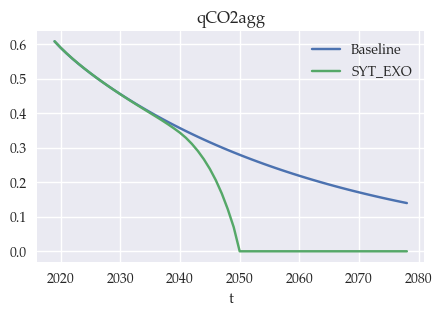

In [10]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO')}), tPlot).plot(figsize=(5,3), title = var);

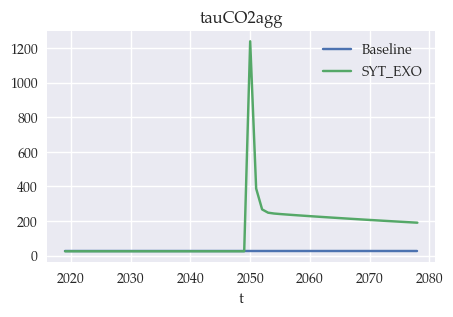

In [11]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO')}), tPlot).plot(figsize=(5,3), title = var);

### SYT_HR

Assume instead that taxes follows a hotelling-like rule in years prior to the target:

In [12]:
state = 'SYT_HR'
M.updateRegulation(state)
M.jSolve(25, state = 'B', runJobOpt = {'checkpoint': cp})
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', state, True)+EV.StaticNCES('H2M', state, True), checkpoint = cp)
M.job.run()
sols[state] = GpyDB(M.job.out_db, ws = ws)

A brief look at how emissions and taxes evolve in baseline and regulated instances:

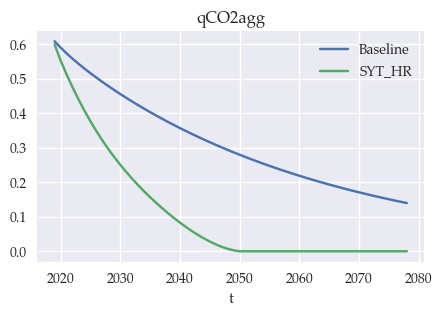

In [13]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline',state)}), tPlot).plot(figsize=(5,3), title = var);

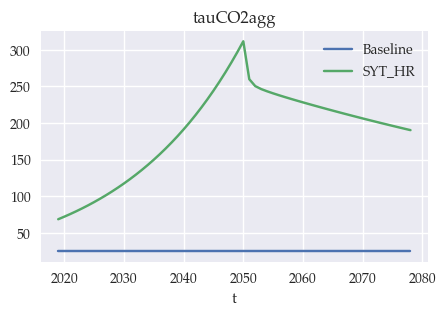

In [14]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline',state)}), tPlot).plot(figsize=(5,3), title = var);

### SYT_OPT

Now, instead, use numerical optimization to determine the path of CO2 taxes. Start from SYT_EXO solution:

In [15]:
[M.db.__setitem__(k, sols['SYT_EXO'][k]) for k in M.db.getTypes(['var']) if k in sols['SYT_EXO'].symbols]; # use solution database
M.db.mergeInternal() # update database
# M.updateRegulation('SYT_OPT')
# sols['SYT_OPT'] = M.solve()

Start solution from SYT_EXO:

In [16]:
M.updateRegulation('SYT_EXO')
M.solve(runJobOpt = {'checkpoint': cp})
M.updateRegulation('SYT_OPT')

Write solve statement for the model (define SYT_OPT model, set lower/upper bounds for taxes):

In [17]:
text = f"""
{M.compiler(M.defineModel(), has_read_file=True)}
# Everything in one go:
tauCO2agg.lo[t]$(t_SYT_NB[t]) = 1; # lower bound >0 for numerical stability.
tauCO2agg.up[t]$(t_SYT_NB[t]) = inf;
{M.solveStatement()}
"""

Solve:

In [18]:
M.job = M.ws.add_job_from_string(text, checkpoint = cp)
M.job.run(checkpoint = cp) # overwrite checkpoint once we are done
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', 'SYT_OPT', True)+EV.StaticNCES('H2M', 'SYT_OPT', True), checkpoint = cp)
M.job.run()
sols['SYT_OPT'] = GpyDB(M.job.out_db, ws = ws)

Illustrate emissions and taxes:

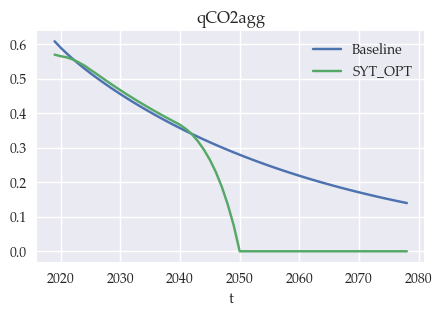

In [19]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_OPT')}), tPlot).plot(figsize=(5,3), title = var);

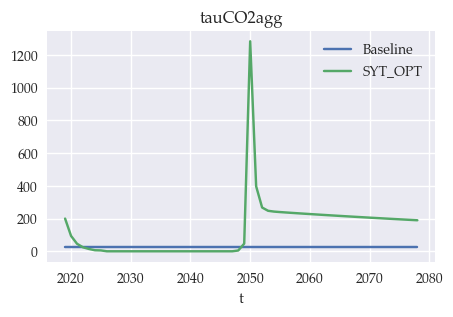

In [20]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_OPT')}), tPlot).plot(figsize=(5,3), title = var);

## 2. LRP 

Update regulation, turn off welfare optimizing module, go back to SYT solution with hotelling rule and solve:

In [21]:
state = 'LRP'
M.updateRegulation(state)
M.opt = False 
[M.db.__setitem__(k, sols['SYT_HR'][k]) for k in M.db.getTypes(['var']) if k in sols['SYT_HR'].symbols]; # use solution database
M.db.mergeInternal() # update database
M.jSolve(5, state = 'B', runJobOpt = {'checkpoint': cp})
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', state, True)+EV.StaticNCES('H2M', state, True), checkpoint = cp)
M.job.run()
sols[state] = GpyDB(M.job.out_db, ws = ws)

Illustrate emissions and taxes: Compare with Hotelling rule solution

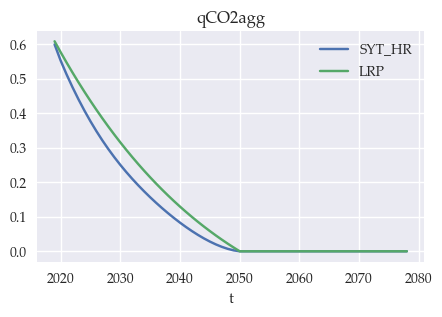

In [22]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('SYT_HR',state)}), tPlot).plot(figsize=(5,3), title = var);

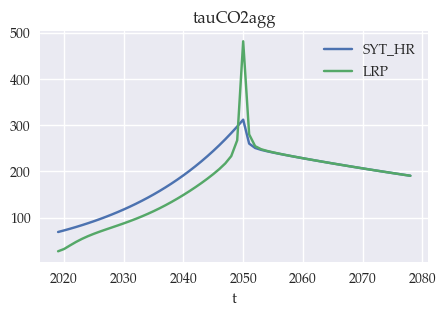

In [23]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('SYT_HR',state)}), tPlot).plot(figsize=(5,3), title = var);

## 3. Emission budget

Update to emission budget rule and solve again:

In [24]:
state = 'EB_HR'
M.updateRegulation(state)
M.opt = False
M.solve(runJobOpt = {'checkpoint': cp})
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', state, True)+EV.StaticNCES('H2M', state, True), checkpoint = cp)
M.job.run()
sols[state] = GpyDB(M.job.out_db, ws = ws)

Plot again:

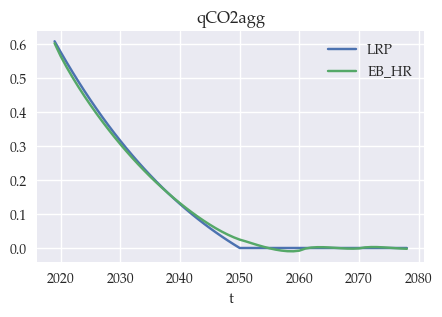

In [25]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR')}), tPlot).plot(figsize=(5,3), title = var);

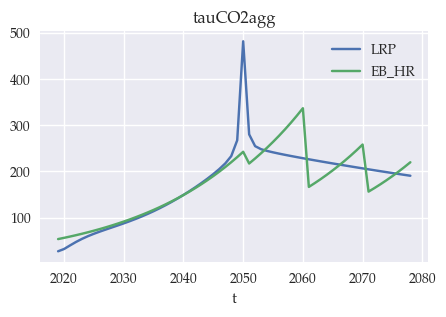

In [26]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR')}), tPlot).plot(figsize=(5,3), title = var);

### EB_OPT

Now, instead, use numerical optimization to determine the path of CO2 taxes. Start from EB_HR solution:

In [27]:
[M.db.__setitem__(k, sols['EB_HR'][k]) for k in M.db.getTypes(['var']) if k in sols['EB_HR'].symbols]; # use solution database
M.db.mergeInternal() # update database
# M.updateRegulation('EB_OPT')
# sols['EB_OPT'] = M.solve()

Solve from EB_HR:

In [28]:
M.updateRegulation('EB_HR')
M.solve(runJobOpt = {'checkpoint': cp})
M.updateRegulation('EB_OPT')

Write solve statement for the model (define EB_OPT model, set lower/upper bounds for taxes):

In [29]:
text = f"""
{M.compiler(M.defineModel(), has_read_file=True)}
# Everything in one go:
tauCO2agg.lo[t]$(t_SYT_NB[t]) = 1; # lower bound >0 for numerical stability.
tauCO2agg.up[t]$(t_SYT_NB[t]) = inf;
{M.solveStatement()}
"""

Solve:

In [30]:
M.job = M.ws.add_job_from_string(text, checkpoint = cp)
M.job.run(checkpoint = cp) # overwrite checkpoint once we are done
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', 'EB_OPT', True)+EV.StaticNCES('H2M', 'EB_OPT', True), checkpoint = cp)
M.job.run()
sols['EB_OPT'] = GpyDB(M.job.out_db, ws = ws)

Plot again:

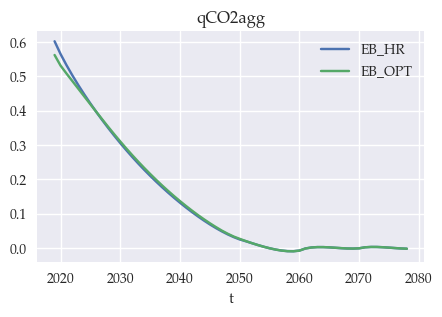

In [31]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('EB_HR','EB_OPT')}), tPlot).plot(figsize=(5,3), title = var);

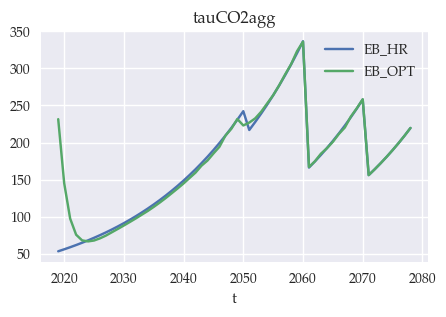

In [32]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('EB_HR','EB_OPT')}), tPlot).plot(figsize=(5,3), title = var);

## 4. Redo budget regulation with agg. emissions from SYT

*Note: Unclear how to formulate an equivalent LPR (either we can jump at 2050 to net zero, or we can change the time it takes to reach net zero).*

* Get aggregate emissions from baseline year to 2050 with regulation SYT_OPT.
* Compute actual emissions instead of growth-adjusted path.
* For emission budgets, simply take the accumulated emissions (non-adjusted) and adjust by relevant target year again (this is how the GAMS code work).
* For the linear reduction path, use the path of actual emissions (non-adjusted) to compute $\Delta$ in the following:
$$
\begin{align}
    \sum_{s=1}^T \left(Q_t-s\Delta\right) = \overline{Q},
\end{align}
$$
where $\overline{Q}$ is the sum of emissions with SYT_OPT regulation. This comes down to
$$
\begin{align}
    \Delta = \dfrac{T Q_t-\overline{Q}}{\sum_{s=1}^T s} = \dfrac{T Q_t-\overline{Q}}{(T+1)T/2}
\end{align}
$$
Use this to compute the linear reduction path and then adjust for growth (as in the modeldata part).

In [33]:
db = sols['SYT_OPT']
growthAdj = (1+db('g_LR'))**(t0-db('qCO2agg').index.to_series())
reversAdj = (1+db('g_LR'))**(db('qCO2agg').index.to_series()-t0)

*Accumulated emissions until 2050:*

In [34]:
qCO20 = sols['Baseline']('qCO2agg').xs(t0)
qCO2 = db('qCO2agg') * reversAdj
Qagg = qCO2.loc[:2050].sum()
QaggAdj = Qagg * growthAdj.xs(2050)

Linear reduction path if we stilll jump to net zero by 2050:

In [35]:
Δ = ((2050-t0+1)*qCO20-Qagg)/((2050-t0+1)*(2050-t0)/2)
qCO2_LRP = pd.Series(qCO20-Δ * range(0, 2050-t0+1), index = pd.Index(range(t0, 2050+1), name = 't'))

### 4.1 EB hotelling

Set solution to SYT_HR, then add new cumulative emission budget. Update state and solve:

In [36]:
state = 'EB_HR_CF'
[M.db.__setitem__(k, sols['SYT_HR'][k]) for k in M.db.getTypes(['var']) if k in sols['SYT_HR'].symbols]; # use solution database
M.db('qCO2_EB').loc[2050] = QaggAdj
M.updateRegulation('EB_HR')
M.opt = False
M.db.mergeInternal()
M.solve(runJobOpt = {'checkpoint': cp})
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', state, True)+EV.StaticNCES('H2M', state, True), checkpoint = cp)
M.job.run()
sols[state] = GpyDB(M.job.out_db, ws = ws)

### 4.2 EB Opt

Use solution from above:

In [37]:
[M.db.__setitem__(k, sols['EB_HR_CF'][k]) for k in M.db.getTypes(['var']) if k in sols['EB_HR_CF'].symbols]; # use solution database
M.db.mergeInternal() # update database

Solve from EB_HR:

In [38]:
M.updateRegulation('EB_HR')
M.solve(runJobOpt = {'checkpoint': cp})
M.updateRegulation('EB_OPT')

Write solve statement for the model (define EB_OPT model, set lower/upper bounds for taxes):

In [39]:
text = f"""
{M.compiler(M.defineModel(), has_read_file=True)}
# Everything in one go:
tauCO2agg.lo[t]$(t_SYT_NB[t]) = 1; # lower bound >0 for numerical stability.
tauCO2agg.up[t]$(t_SYT_NB[t]) = inf;
{M.solveStatement()}
"""

Solve:

In [40]:
M.job = M.ws.add_job_from_string(text, checkpoint = cp)
M.job.run(checkpoint = cp) # overwrite checkpoint once we are done
M.job = M.ws.add_job_from_string(EV.Ramsey('Ramsey', 'EB_OPT_CF', True)+EV.StaticNCES('H2M', 'EB_OPT_CF', True), checkpoint = cp)
M.job.run()
sols['EB_OPT_CF'] = GpyDB(M.job.out_db, ws = ws)

## 5. Plots

Compare qCO2agg for Baseline, SYT_EXO, SYT_HR, SYT_OPT og LRP:

In [41]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=long_colors)

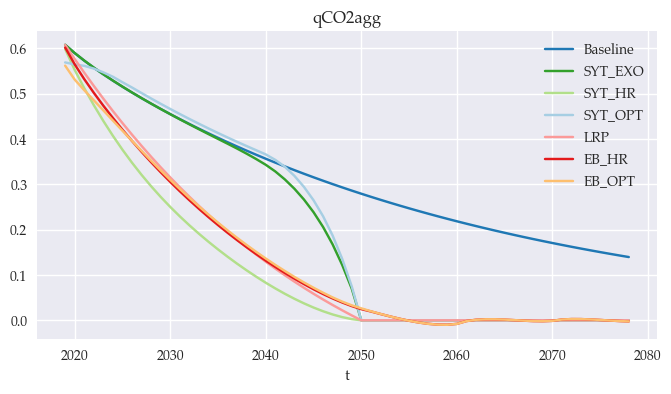

In [42]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO','SYT_HR','SYT_OPT','LRP','EB_HR','EB_OPT')}), tPlot).plot(figsize=(8,4), title = var);

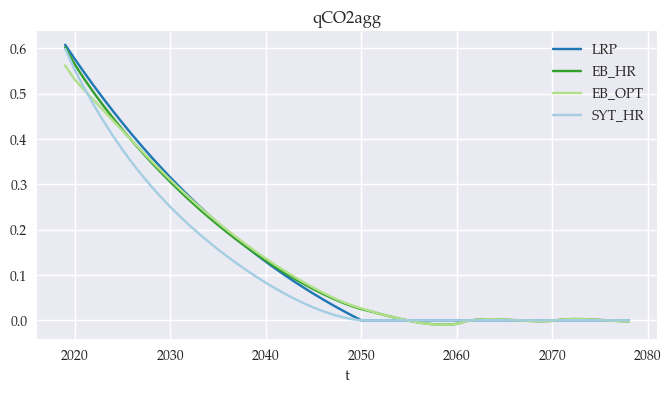

In [43]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR','EB_OPT','SYT_HR')}), tPlot).plot(figsize=(8,4), title = var);

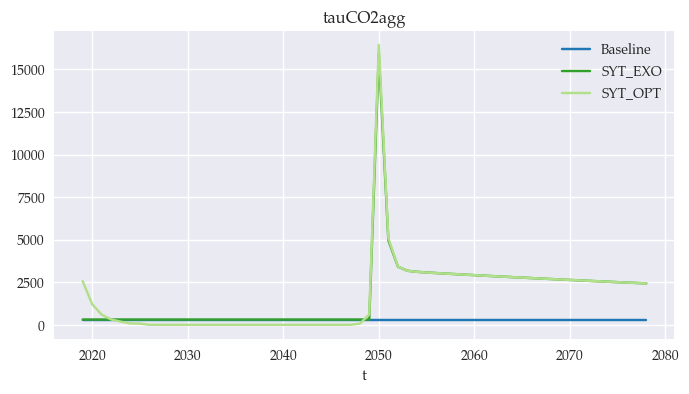

In [44]:
mult = scale/(M.db('M1990') * 1e6)
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var)*mult for k in ('Baseline','SYT_EXO','SYT_OPT')}), tPlot).plot(figsize=(8,4), title = var);

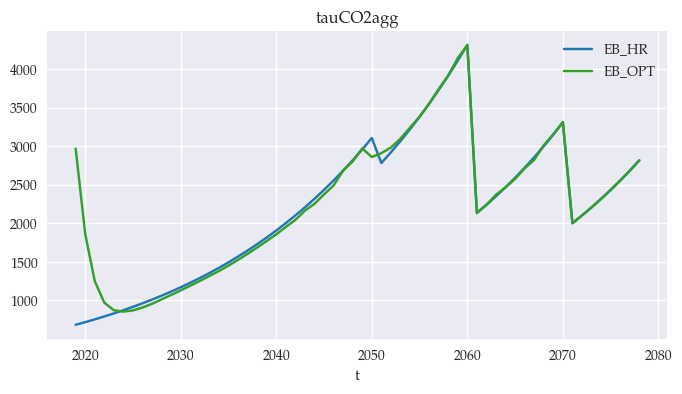

In [45]:
adj.rc_pd(pd.DataFrame({k: sols[k](var)*mult for k in ('EB_HR','EB_OPT')}), tPlot).plot(figsize=(8,4), title = var);

### Compare welfare

In [46]:
EV_HH = pd.concat([sols[state]('EV').unstack(level='state')[state] for state in EV.states if state != EV.base], axis =1)
EVagg = EV_HH.groupby('t').sum()

Plot aggregate EVs in 2019 across states:

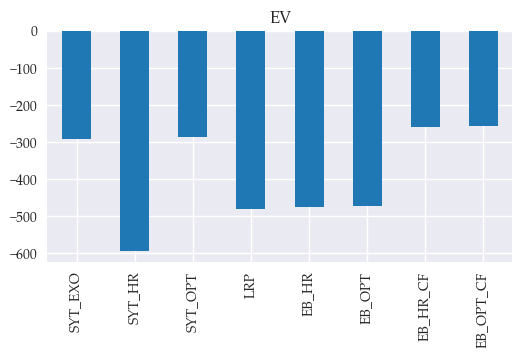

In [47]:
EVagg.xs(2019).plot.bar(title = 'EV', figsize=(6,3));

Plot EVs for household types:

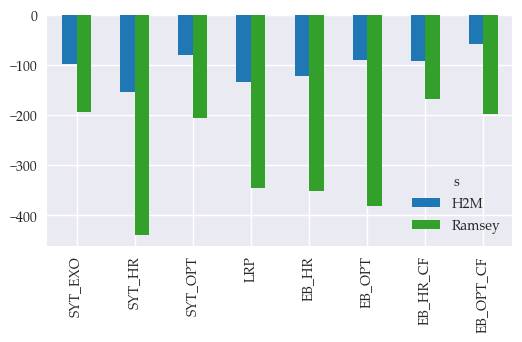

In [48]:
EV_HH.xs(2019).stack().unstack(level='s').plot.bar(figsize=(6,3));

Split into components:

In [49]:
EVtypes = dict.fromkeys(['HInc', 'WInc','TInc','ZInc','vA','pV'])
for k in EVtypes:
    EVtypes[k] = pd.concat([sols[state](f'EV_{k}').unstack(level='state')[state] for state in EV.states if state != EV.base], axis =1)

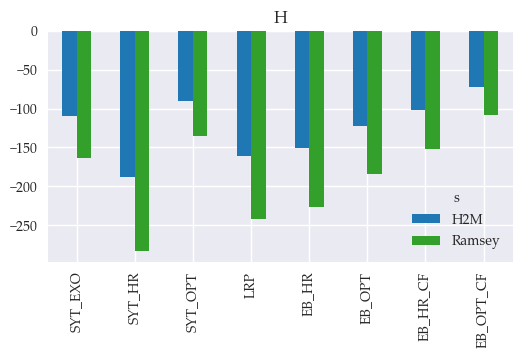

In [50]:
EVtypes['HInc'].xs(2019).stack().unstack(level='s').plot.bar(title = 'H', figsize=(6,3));

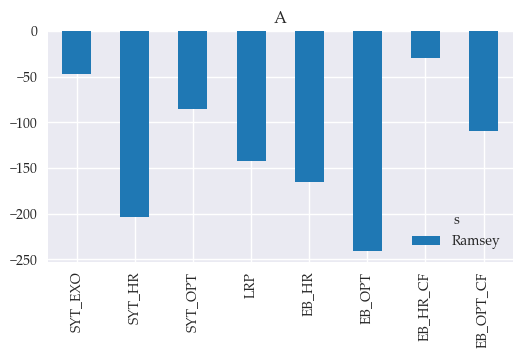

In [51]:
EVtypes['vA'].xs(2019).stack().unstack(level='s').plot.bar(title = 'A', figsize=(6,3));

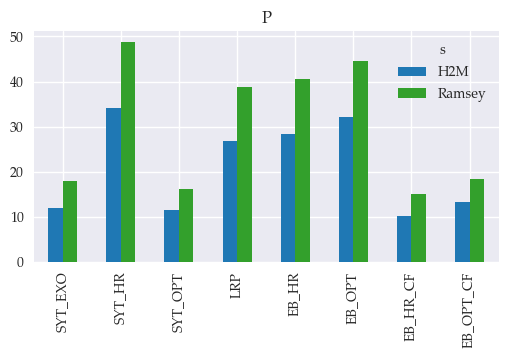

In [52]:
EVtypes['pV'].xs(2019).stack().unstack(level='s').plot.bar(title = 'P', figsize=(6,3));

Opdeling af H:

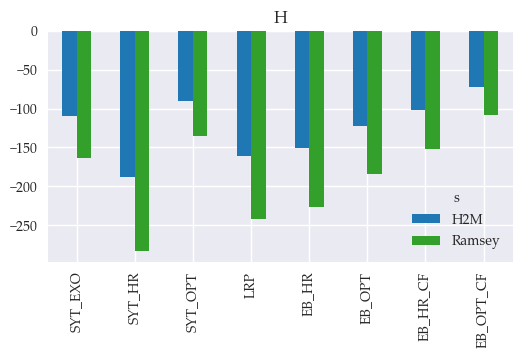

In [53]:
EVtypes['HInc'].xs(2019).stack().unstack(level='s').plot.bar(title = 'H', figsize=(6,3));

In [54]:
EVtypes['pV'].xs(2019).multiply(1/db('uHH'), axis = 0)

SYT_EXO     SYT_HR    SYT_OPT        LRP      EB_HR     EB_OPT  \
s                                                                          
H2M     30.030076  85.543053  28.894541  67.079829  70.678265  80.171185   
Ramsey  29.724637  81.310544  26.830629  64.617493  67.558771  74.208384   

         EB_HR_CF  EB_OPT_CF  
s                             
H2M     25.431082  33.463723  
Ramsey  25.218239  30.634757